In [1]:
import pprint
from sklearn.metrics import mean_absolute_error
from minepy import MINE
import numpy as np  # Run PTP simulation
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import allantools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import moment
from scipy.signal import decimate, resample
from scipy.spatial.distance import correlation as dist_corr
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Lambda
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/py

In [4]:
# Importing Data
data_csv = "wind_1.csv"
dataframe = pd.read_csv(data_csv, header=None)
wind_april = dataframe.values
wind_april = wind_april.flatten()

data_csv = "wind_2.csv"
dataframe = pd.read_csv(data_csv, header=None)
wind_may = dataframe.values
wind_may = wind_may.flatten()

wind = np.concatenate((wind_april,wind_may))


In [5]:
total = 
table_df = {'Lote de dados': ['Treino','Validação','Teste','Total'],'Porcentagem':[60,20,20,100], 'Total':total}
table_df = pd.DataFrame(data=table_df)
table_df.to_csv('divisão_de_dados')

8780


In [ ]:
# Autocorrelation function
# If frequency offset is non stationary the autocorrelation plot will show periodic behavior
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
# pd.plotting.autocorrelation_plot(norm_diff_freq)
pd.plotting.autocorrelation_plot(norm_diff_freq)
plt.show()


In [12]:
# Lag matrix
# Check the autocorrelation matrix
# Generating the autocorrelation to each lag
wind_test = wind
x = wind_test
x1 = wind_test 
lag = np.arange(1,100,1)
start = lag[-1]
end = len(x)
R = [x[start - i : end - i] for i in lag]
R1 = [x1[start - i : end - i] for i in lag]
R2 = [R1[0] for i in lag]
r = np.corrcoef(R1,R)
corr = np.abs(r[0][len(lag):])
print("Absolute  cross correlation is bigger than 0.7 for the lags:")
print(np.where(corr > 0.5))

temp_dist_corr = np.array([dist_corr(i[0],i[1])/2 for i in zip(R2,R)])
print(np.where(temp_dist_corr > 0.7))

Absolute  cross correlation is bigger than 0.7 for the lags:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40]),)
(array([], dtype=int64),)


In [13]:
print(corr)

[1.         0.95505082 0.92232663 0.89810172 0.87675461 0.85716223
 0.83860194 0.82061691 0.80542693 0.79156401 0.78017303 0.76904993
 0.75672479 0.74425474 0.73214471 0.72169723 0.71196893 0.70113636
 0.68885912 0.67672742 0.66496336 0.65643928 0.64833097 0.63894477
 0.63072492 0.62272483 0.6157779  0.60818495 0.59925935 0.59075388
 0.5838762  0.57573738 0.56597553 0.55788166 0.55054074 0.54355046
 0.53685726 0.52915409 0.52047426 0.51254014 0.50419161 0.49557547
 0.4871367  0.47933548 0.47185442 0.46578724 0.45963738 0.45315687
 0.44595057 0.44024236 0.43463187 0.42898429 0.42453512 0.41925335
 0.4145965  0.40937578 0.40400731 0.39975735 0.39776336 0.39425461
 0.39007805 0.38548544 0.38180575 0.37744015 0.37391804 0.36951276
 0.36599896 0.36066563 0.35582404 0.35294128 0.34929014 0.34606816
 0.34315811 0.33892477 0.33638727 0.33563937 0.33353669 0.3311384
 0.32876501 0.32509349 0.32084051 0.32023217 0.31927483 0.3183051
 0.31774772 0.31762749 0.31867584 0.31916731 0.31765178 0.317062

In [14]:
N = 40
n_windows = len(wind) - N

feature_mtx = np.zeros((n_windows, N))
label_mtx = np.zeros((n_windows, 1))

for i in range(0, n_windows):
    # Window start and end indexes
    i_s = i
    i_e = i + N
    # Temperature data
    wind_i = wind[i_s : i_e]
    features = wind_i
    # Label: the first freq. offset of the next window, so that the NN is trained to predict
    label = wind[i_e]
    # Save
    feature_mtx[i, :] = features
    label_mtx[i, :] = label


# Split
x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(
    feature_mtx,
    label_mtx,
    np.arange(0, n_windows),
    test_size=0.4,
    shuffle=False,
    random_state=42,
)
# Shuffle post split data
# x_train, y_train, i_train = shuffle(x_train, y_train, i_train, random_state=42)

# Normalization gains based on training data
#
# NOTE: feature_mtx is (m x n_x), where m is the no. of training
# samples. Namely, features are along x axis (columns).
# Compute the maximum of each column and normalize using that.
# Normalize the datasets
min = np.min(x_train)
max = np.max(x_train)

x_train = (x_train - min) / (max - min)
x_test = (x_test - min)/(max - min)

Text(0, 0.5, 'ppb')

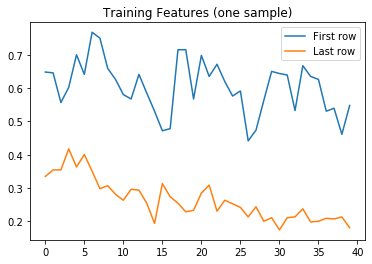

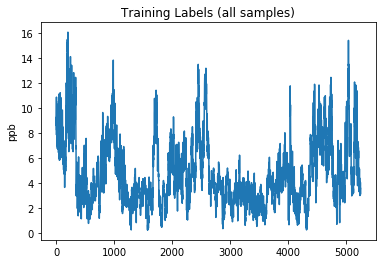

In [15]:
plt.figure()
plt.plot(x_train[0, :], label="First row")
plt.plot(x_train[-1, :], label="Last row")
plt.title("Training Features (one sample)")
plt.legend()

plt.figure()
plt.plot(y_train)
plt.title("Training Labels (all samples)")
plt.ylabel("ppb")

In [16]:
H1 = 50
H2 = 50
n_epochs = 200
lr = 0.001  # learning rate
lr_decay = 0.001  # learning rate decay
n_mini_batch = 100  # mini-batch length
activation_fcn = "sigmoid"
optimizer = Adam(lr=lr, decay=lr_decay)

model = Sequential()
model.add(
    Dense(input_dim=(x_train.shape[1]), units=H1, activation=activation_fcn)
)
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="linear"))
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    batch_size=n_mini_batch,
    epochs=n_epochs,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", min_delta=0.01, patience=10, verbose=1
        )
    ],
)
model.save("model.h1")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 4719 samples, validate on 525 samples
Epoch 1/200
4719/4719 [==============================] - 2s 363us/step - loss: 12.5088 - val_loss: 8.6228
Epoch 2/200
4719/4719 [==============================] - 0s 40us/step - loss: 7.9947 - val_loss: 9.2825
Epoch 3/200
4719/4719 [==============================] - 0s 39us/step - loss: 7.9279 - val_loss: 9.0476
Epoch 4/200
4719/4719 [==============================] - 0s 39us/step - loss: 7.7998 - val_loss: 9.1005
Epoch 5/200
4719/4719 [==============================] - 0s 40us/step - loss: 7.7898 - val_loss: 9.4428
Epoch 6/200
4719/4719 [==============================] - 0s 40us/step - loss: 7.7884 - val_loss: 8.8661
Epoch 7/200
4719/4719 [==============================] - 0s 41us/step - loss: 7.5733 - val_loss: 9.3561
Epoch 8/200
4719/4719 [==============================] - 0s 43us/step - loss: 7.3676 - val_loss: 8.089

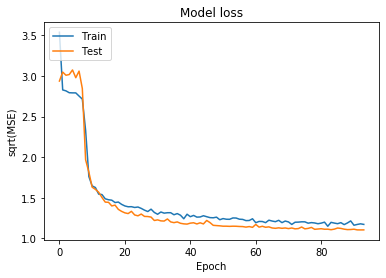

In [17]:
# Plot training & validation loss values
plt.figure()
plt.plot(np.sqrt(history.history["loss"]))
plt.plot(np.sqrt(history.history["val_loss"]))
plt.title("Model loss")
plt.ylabel("sqrt(MSE)")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")

Text(0, 0.5, 'ppb')

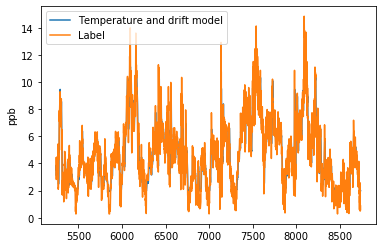

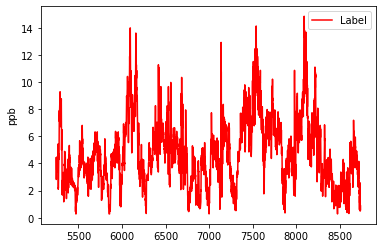

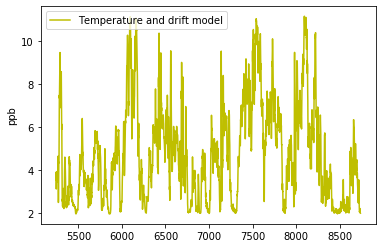

In [18]:
# Test some predictions
y_nn= model.predict(x_test)
y_nn = y_nn.flatten()
n_pred = len(y_nn)

plt.figure()
plt.plot(i_test, y_nn, label="Temperature and drift model")
plt.plot(i_test, y_test.flatten(), label="Label")
plt.legend()
plt.ylabel("ppb")

plt.figure()
plt.plot(i_test, y_test.flatten(),'r' ,label="Label")
plt.legend()
plt.ylabel("ppb")

plt.figure()
plt.plot(i_test, y_nn, 'y',label="Temperature and drift model")
plt.legend()
plt.ylabel("ppb")

[NN TEMP] Variance:   0.80 Mean:   0.01
[NN TEMP] MAE:       0.644294 


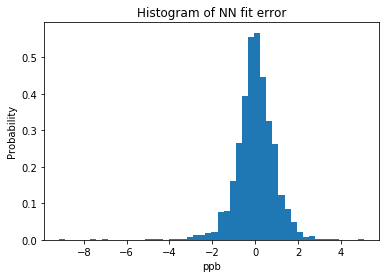

In [19]:
y_nn_temp_err = y_nn - y_test.flatten()

print(
    "[NN TEMP] Variance: %6.2f Mean: %6.2f"
    % (np.var(y_nn_temp_err), np.mean(y_nn_temp_err))
)
print("[NN TEMP] MAE:       %f " % mean_absolute_error(y_nn, y_test))

plt.figure()
plt.hist(y_nn_temp_err, bins=50, density=True)
plt.title("Histogram of NN fit error")
plt.xlabel("ppb")
plt.ylabel("Probability")

plt.show()

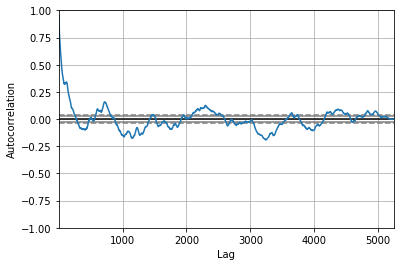

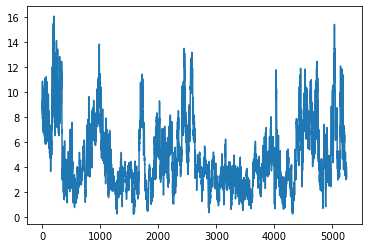

In [20]:
# ARIMA holdover
# The holdover approach is currently a univariate timeseries
# For this purpose the ARIMA model performs well
# Split

# y_train, y_test = train_test_split(
#     wind,
#     test_size=0.4,
#     shuffle=False,
#     random_state=42,
# )

# train data autocorrelation to find the d parameter
p_order    = 5
d_order    = 0 # Differencing order
q_order    = 0

if d_order > 0:
    train_diff = np.array(y_train[d_order:]) - np.array(y_train[:-d_order])
else:
    train_diff = y_train


fig = plt.figure()
pd.plotting.autocorrelation_plot(train_diff)

plt.show()

# The time series data used to train the model
fig = plt.figure()
plt.plot(train_diff.reshape(train_diff.size,1))

plt.show()

In [21]:
y_train   = y_train.flatten()
y_train   = y_train.tolist()

In [22]:
# Defining the prediction model

arima_pred = list()


pred_scope  = 40
pred_size   = 100
buffer      = y_train[-1*pred_scope:]
y_arima     = []
for i in range(0,pred_size):
    arima_model = ARIMA(buffer, order=(p_order,d_order,q_order))
    arima_fit   = arima_model.fit(disp=0)
    arima_pred  = arima_fit.forecast(1)[0]
    buffer[:pred_scope-1]   = buffer[1:]
    buffer[-1] = y_test[i]
    y_arima.append(arima_pred)




/home/rodrigo/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/rodrigo/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rodrigo/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/rodrigo/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/rodrigo/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check ml

[ARIMA]   Variance:   0.59 Mean:  -0.04
[ARIMA]   MAE:       0.587658 
[NN] Variance:   0.93 Mean:  -0.01
[NN] MAE:       0.743473 
[Naive] Variance:   0.73 Mean:  -0.04
[Naive] MAE:       0.572700 


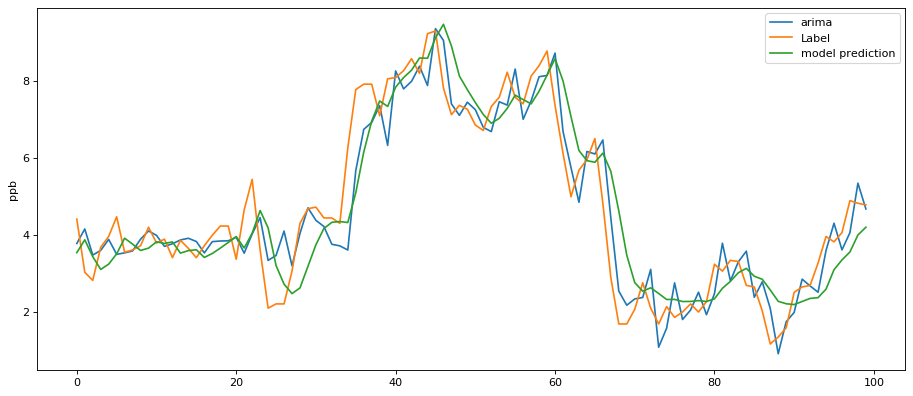

In [23]:
plot_size = len(y_arima)
yh_test_r = y_test.flatten()
yh_test_p = yh_test_r[:plot_size]
y_nn_p    = y_nn[:plot_size]

# ARIMA results
y_arima = np.array(y_arima).flatten()
naive = np.concatenate((yh_test_p[1:],[0]))
fig = plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.arange(0, len(y_arima)), y_arima, label="arima")
plt.plot(np.arange(0, len(yh_test_p)), yh_test_p, label="Label")
plt.plot(np.arange(0, len(y_nn_p)), y_nn_p, label="model prediction")
#plt.plot(np.arange(0, len(y_nn_p)), naive, label="naive prediction")
plt.legend()
plt.ylabel("ppb")

# Holdover error
arima_err = y_arima - yh_test_p
y_nn_temp_err = y_nn_p - yh_test_p
naive_err = naive -  yh_test_p
# 100 step error
print("[ARIMA]   Variance: %6.2f Mean: %6.2f"%(np.var(arima_err), np.mean(arima_err)))
print("[ARIMA]   MAE:       %f " %mean_absolute_error(y_arima, yh_test_p))

print(
    "[NN] Variance: %6.2f Mean: %6.2f"
    % (np.var(y_nn_temp_err), np.mean(y_nn_temp_err))
)
print("[NN] MAE:       %f " % mean_absolute_error(y_nn_p, yh_test_p))

print(
    "[Naive] Variance: %6.2f Mean: %6.2f"
    % (np.var(naive_err), np.mean(naive_err))
)
print("[Naive] MAE:       %f " % mean_absolute_error(naive, yh_test_p))